<a href="https://colab.research.google.com/github/vaskar22/Credit-Card-Fraud-Detection/blob/main/Notebook/creditcard_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit Card Fraud Detection**




### **Context**
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## -------------------------------------------------------------------------------
### **Content**
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


In [1]:
#importing packages
%matplotlib inline
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
# Import data set
data=pd.read_csv('/content/drive/MyDrive/creditcard.csv/creditcard.csv')

In [3]:
# Explore data set
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
# some information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### visualizations of time and amount

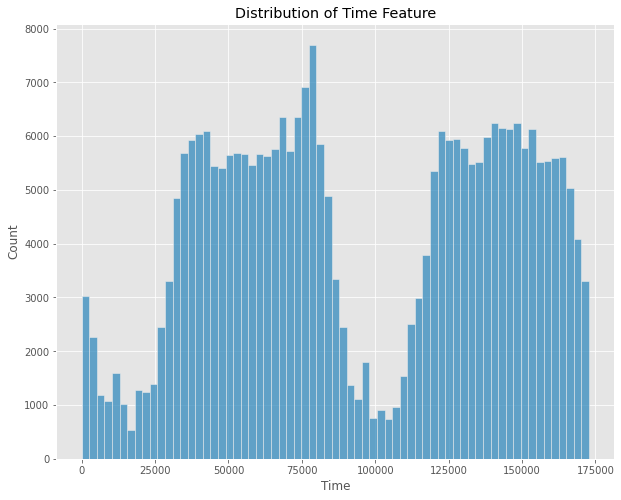

In [5]:
# Time
plt.figure(figsize=(10,8))
plt.title('Distribution of Time Feature')
sns.histplot(data.Time)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


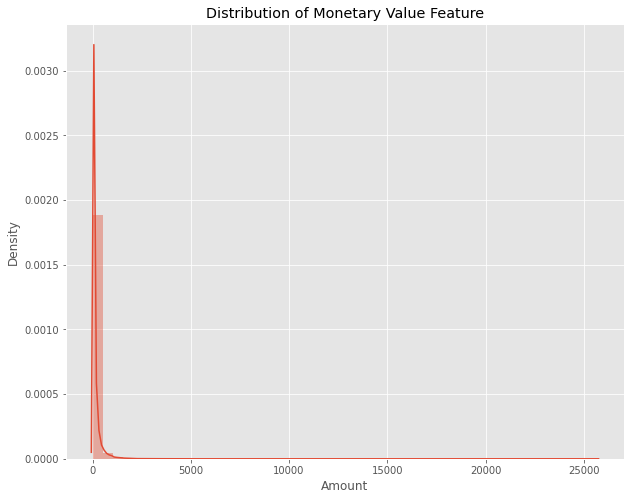

In [6]:
plt.figure(figsize=(10,8))
plt.title('Distribution of Monetary Value Feature')
sns.distplot(data.Amount)

Around 88 dollars is the mean of all credit card transactions in this data set. The biggest transaction had a monetary value of around 25,691 dollars.

### visualizations of target columns

In [7]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
counts = data.Class.value_counts()
normal = counts[0]
fraudulent = counts[1]

Text(0.5, 0, 'Class (0:Non-Fraudulent, 1:Fraudulent)')

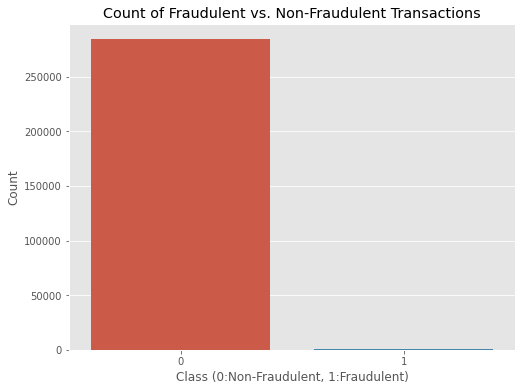

In [9]:
plt.figure(figsize=(8,6))
sns.barplot(x=counts.index, y=counts)
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.xlabel('Class (0:Non-Fraudulent, 1:Fraudulent)')

In [10]:
per_normal = (normal/(normal+fraudulent))*100
per_fraudulent = (fraudulent/(normal+fraudulent))*100
print('There were {} non-fraudulent transactions ({:.3f}%) and {} fraudulent transactions ({:.3f}%).'.format(normal, per_normal, fraudulent, per_fraudulent))

There were 284315 non-fraudulent transactions (99.827%) and 492 fraudulent transactions (0.173%).


**Note:** Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

## There are 492 cases of fraud in our dataset so we can randomly get 492 cases of non-fraud to create our new sub dataframe.We concat the 492 cases of fraud and non fraud, creating a new sub-sample.

In [11]:
## Non fraud
nonfraud_sample=data.loc[data.Class==0].sample(492)

In [12]:
## fraud sample
fraud_sample=data.loc[data.Class==1]

In [13]:
sample_data=pd.concat([fraud_sample,nonfraud_sample]) # merge two data frame to a single data frame

In [14]:
sample_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31935,36569.0,-1.411905,1.058241,1.169883,-0.273733,-0.291469,-0.025482,0.215623,0.238549,0.438674,0.865641,1.138428,-0.266792,-1.724124,0.319754,0.715491,0.169936,-0.410795,0.384833,-0.356273,0.099325,0.241404,0.837141,-0.040266,0.009845,-0.438799,0.384347,0.167448,0.402024,24.55,0
262901,160703.0,-0.197689,0.649519,0.935955,-0.947560,0.261699,-0.540526,0.425608,-0.829834,-0.354498,-0.726765,0.840880,0.466203,-1.195666,0.685144,-0.972645,0.345057,-0.580220,-0.434722,-0.461848,-0.374706,0.423543,-1.365861,-0.365952,-0.008910,1.524143,0.338145,-0.040049,0.100651,1.29,0
15252,26607.0,-0.317827,1.332732,0.474231,1.287059,0.835306,-0.282303,1.479240,-0.198245,-1.655507,0.473757,0.666288,0.601214,0.534809,0.406983,-1.355440,0.752320,-1.232508,0.122635,-1.118534,-0.199099,0.225023,0.565337,-0.031044,0.020711,-0.741533,-0.295830,0.065586,0.198844,61.98,0
155939,106843.0,0.335848,0.264934,-0.456754,-1.796639,0.071405,-0.179060,-0.931425,-2.960680,0.145604,-0.908006,-0.221363,-2.601142,1.904934,1.588601,-2.023328,1.098487,0.819500,-1.627791,-0.347460,0.605537,-1.405878,0.134113,0.082717,0.519561,0.303778,-0.528467,0.098085,0.313957,29.70,0


In [15]:
# shuffle data set
sample_data=sample_data.sample(frac=1).reset_index(drop=True)

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler2 = StandardScaler()
#scaling time
scaled_time = scaler.fit_transform(sample_data[['Time']])
flat_list1 = [item for sublist in scaled_time.tolist() for item in sublist]
scaled_time = pd.Series(flat_list1)

In [17]:
#scaling the amount column
scaled_amount = scaler2.fit_transform(sample_data[['Amount']])
flat_list2 = [item for sublist in scaled_amount.tolist() for item in sublist]
scaled_amount = pd.Series(flat_list2)

In [18]:
#concatenating newly created columns w original df
sample_data = pd.concat([sample_data, scaled_amount.rename('scaled_amount'), scaled_time.rename('scaled_time')], axis=1)
sample_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
0,148053.0,1.261324,2.726800,-5.435019,5.342759,1.447043,-1.442584,-0.898702,0.123062,-2.748496,-3.202436,1.991361,-3.986416,0.577207,-8.485795,-0.794782,-0.666134,-1.372629,-0.104313,-1.466911,0.313332,0.209086,-0.425938,-0.154440,-0.018820,0.632234,0.192922,0.468181,0.280486,1.59,1,-0.431789,1.203706
1,139117.0,-3.975939,-1.244939,-3.707414,4.544772,4.050676,-3.407679,-5.063118,1.007042,-3.190158,-4.250717,4.182162,-4.563675,1.182503,-6.964972,1.115340,-4.997332,-6.419539,-1.183593,3.569733,2.109403,1.059737,-0.037395,0.348707,-0.162929,0.410531,-0.123612,0.877424,0.667568,8.30,1,-0.403864,1.022018
2,8614.0,-2.169929,3.639654,-4.508498,2.730668,-2.122693,-2.341017,-4.235253,1.703538,-1.305279,-6.716720,6.353612,-8.601648,0.449930,-7.506169,-0.438082,-3.694516,-6.304753,-1.267587,0.357987,0.500779,0.645103,-0.503529,-0.000523,0.071696,0.092007,0.308498,0.552591,0.298954,1.00,1,-0.434244,-1.631392
3,63578.0,-0.639191,-0.085595,1.265452,1.401166,-0.260542,1.009795,1.301999,-0.135258,-0.431521,-0.091353,-0.921052,-0.613816,0.198913,0.016087,2.206264,-0.527141,-0.057279,0.448656,1.164435,0.861307,0.340331,0.760170,0.353377,-0.778893,-0.070681,-0.033355,-0.061962,-0.062687,290.18,1,0.769233,-0.513854
4,129808.0,1.522080,-0.519429,-2.581685,0.774741,0.206722,-1.431020,0.757011,-0.444418,0.997921,-1.429490,-0.375466,0.179095,-0.148449,-2.135155,-0.044916,-0.055333,1.778697,0.671832,-0.002021,0.361169,0.019649,-0.211678,-0.247452,-0.279472,0.239646,-0.508398,-0.015551,0.041881,276.17,1,0.710928,0.832746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,154181.0,-0.549615,2.219075,-3.522024,0.236995,1.087469,-1.235530,-0.279313,0.514361,-1.849927,-3.443819,2.214000,-1.689836,0.498438,-4.393634,-1.270841,-1.176629,-1.859739,-0.049419,0.385263,0.126518,0.364130,0.210428,-0.366019,0.015803,0.349212,0.647302,0.171929,0.117188,0.76,1,-0.435243,1.328302
980,47826.0,-0.887287,1.390002,1.219686,1.661425,1.009228,-0.733908,0.855829,0.000077,-1.275631,-0.433394,0.141179,-0.460348,-0.367868,-1.168339,0.152108,0.882232,0.601805,-0.304092,-2.191764,-0.268347,-0.083734,-0.346930,-0.050619,0.231044,-0.450760,-0.376205,0.034504,0.157775,7.58,1,-0.406860,-0.834127
981,136061.0,-4.459348,-1.063647,-1.843892,-0.796618,-1.145283,-0.591828,0.513389,0.734114,-0.931552,0.268301,-1.610033,0.021986,0.674217,0.693544,0.252647,-1.130086,0.044286,1.603498,-0.986094,-1.334057,-0.311373,0.404943,-0.029785,0.751712,0.763229,-0.012850,0.273284,-0.218004,172.50,0,0.279486,0.959883
982,121238.0,-2.628922,2.275636,-3.745369,1.226948,-1.132966,-1.256353,-1.752420,0.281736,-1.792343,-4.820779,4.176098,-4.619010,0.742690,-7.636963,-0.197888,-4.140396,-7.604715,-1.524505,1.271322,0.133106,0.870730,1.269473,-0.265494,-0.480549,0.169665,0.096081,0.070036,0.063768,144.62,1,0.163458,0.658499


In [19]:
#dropping old amount and time columns
sample_data.drop(['Amount', 'Time'], axis=1, inplace=True)

In [20]:
# correlation matrix
corr_matrix=sample_data.corr()

In [21]:
corr_Class=corr_matrix[['Class']]
corr_Class

,Class
V1,-0.427031
V2,0.490297
V3,-0.567649
V4,0.714967
V5,-0.380123
V6,-0.387951
V7,-0.479139
V8,0.055030
V9,-0.560104
V10,-0.627274


- since the columns are unknown ,so I will take only highly correlated columns

In [22]:
# positive correlations greater than 0.5
corr_Class[corr_Class.Class>0.5]

,Class
V4,0.714967
V11,0.692637
Class,1.000000


In [23]:
# negative correlations smaller than -0.5
corr_Class[corr_Class.Class<-0.5]

,Class
V3,-0.567649
V9,-0.560104
V10,-0.627274
V12,-0.685864
V14,-0.751174
V16,-0.592075
V17,-0.557413


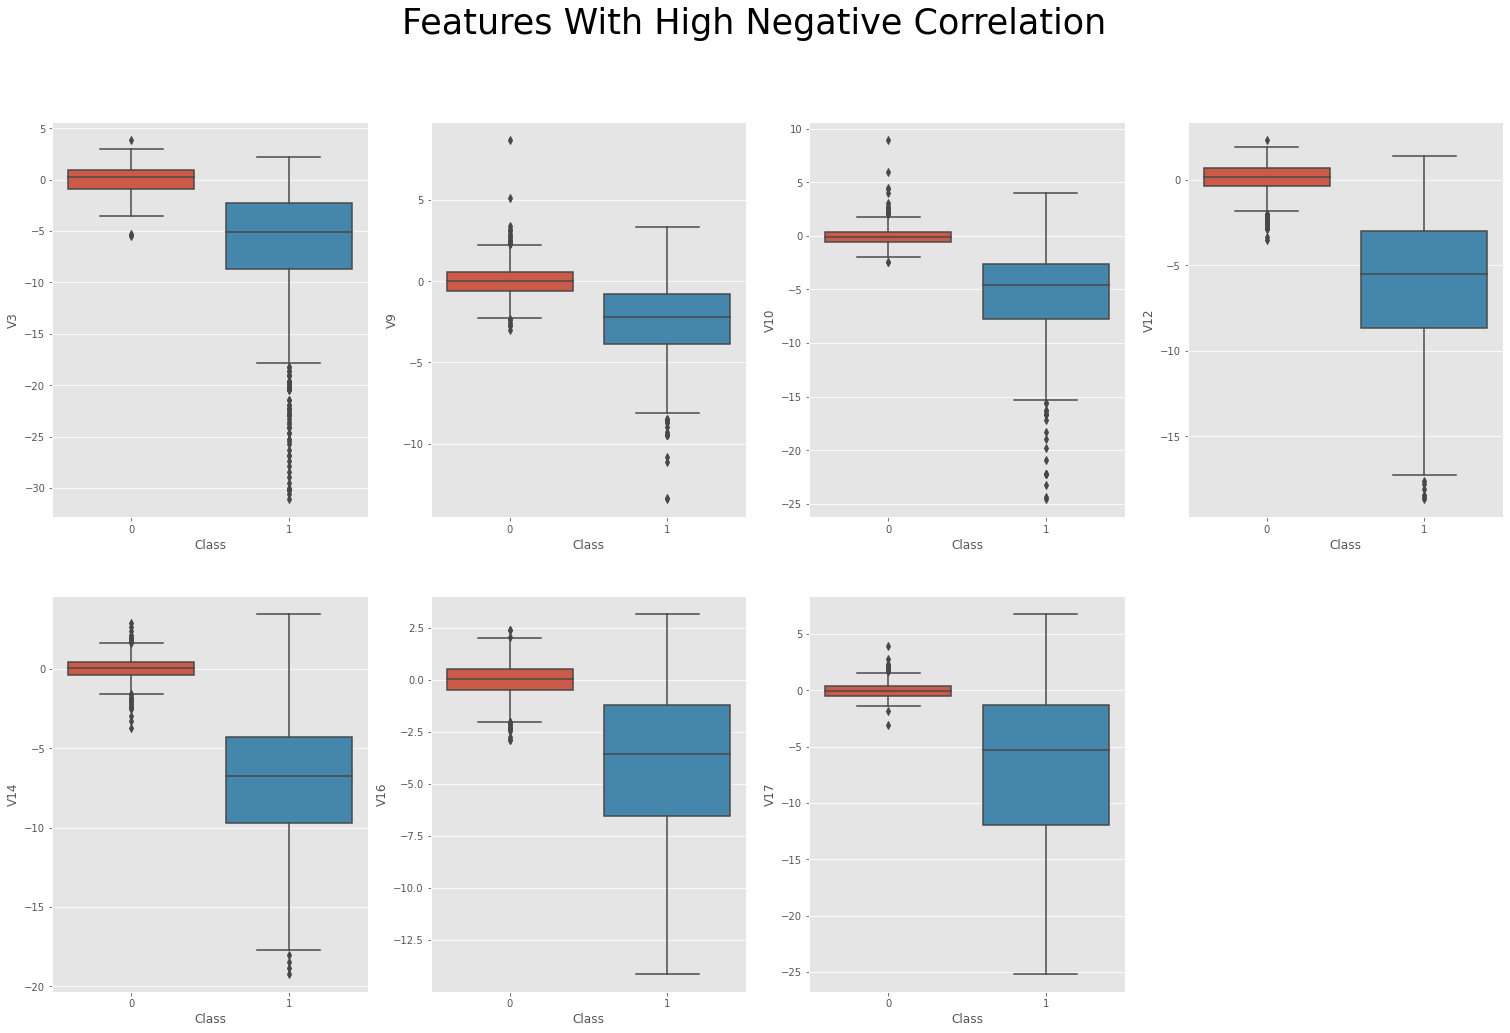

In [24]:
#visualizing the features w high negative correlation
f, axes = plt.subplots(nrows=2, ncols=4, figsize=(26,16))

f.suptitle('Features With High Negative Correlation', size=35)
sns.boxplot(x="Class", y="V3", data=sample_data, ax=axes[0,0])
sns.boxplot(x="Class", y="V9", data=sample_data, ax=axes[0,1])
sns.boxplot(x="Class", y="V10", data=sample_data, ax=axes[0,2])
sns.boxplot(x="Class", y="V12", data=sample_data, ax=axes[0,3])
sns.boxplot(x="Class", y="V14", data=sample_data, ax=axes[1,0])
sns.boxplot(x="Class", y="V16", data=sample_data, ax=axes[1,1])
sns.boxplot(x="Class", y="V17", data=sample_data, ax=axes[1,2])
f.delaxes(axes[1,3])

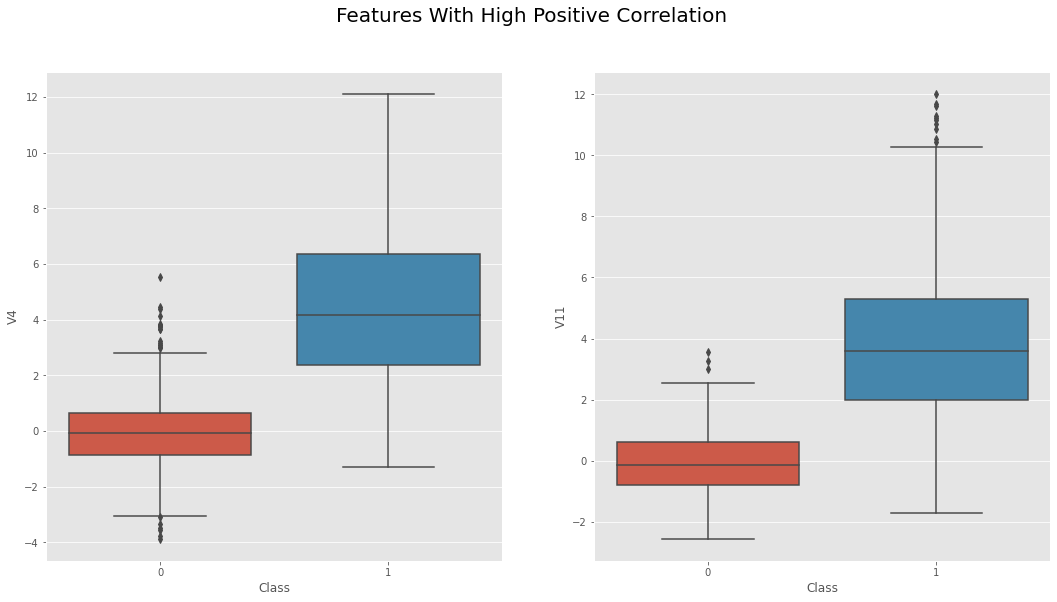

In [25]:
# visualizing the features w high positive correlation
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,9))

f.suptitle('Features With High Positive Correlation', size=20)
sns.boxplot(x="Class", y="V4", data=sample_data, ax=axes[0])
sns.boxplot(x="Class", y="V11", data=sample_data, ax=axes[1])

### Only removing extreme outlier

In [26]:
Q1 = sample_data.quantile(0.25)
Q3 = sample_data.quantile(0.75)
IQR = Q3 - Q1
IQR

V1               3.870188
V2               2.924665
V3               5.492646
V4               4.387205
V5               2.268933
V6               1.609084
V7               3.362067
V8               1.122101
V9               2.474542
V10              4.587306
V11              3.864556
V12              5.749404
V13              1.453238
V14              6.826242
V15              1.246992
V16              3.825663
V17              5.489726
V18              2.091493
V19              1.398019
V20              0.626119
V21              0.843249
V22              1.164514
V23              0.436488
V24              0.763762
V25              0.715542
V26              0.596033
V27              0.500583
V28              0.275297
Class            1.000000
scaled_amount    0.409739
scaled_time      1.867175
dtype: float64

In [27]:
df= sample_data[~((sample_data < (Q1 - 2.5 * IQR)) |(sample_data > (Q3 + 2.5 * IQR))).any(axis=1)]

In [28]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,1.261324,2.726800,-5.435019,5.342759,1.447043,-1.442584,-0.898702,0.123062,-2.748496,-3.202436,1.991361,-3.986416,0.577207,-8.485795,-0.794782,-0.666134,-1.372629,-0.104313,-1.466911,0.313332,0.209086,-0.425938,-0.154440,-0.018820,0.632234,0.192922,0.468181,0.280486,1,-0.431789,1.203706
2,-2.169929,3.639654,-4.508498,2.730668,-2.122693,-2.341017,-4.235253,1.703538,-1.305279,-6.716720,6.353612,-8.601648,0.449930,-7.506169,-0.438082,-3.694516,-6.304753,-1.267587,0.357987,0.500779,0.645103,-0.503529,-0.000523,0.071696,0.092007,0.308498,0.552591,0.298954,1,-0.434244,-1.631392
3,-0.639191,-0.085595,1.265452,1.401166,-0.260542,1.009795,1.301999,-0.135258,-0.431521,-0.091353,-0.921052,-0.613816,0.198913,0.016087,2.206264,-0.527141,-0.057279,0.448656,1.164435,0.861307,0.340331,0.760170,0.353377,-0.778893,-0.070681,-0.033355,-0.061962,-0.062687,1,0.769233,-0.513854
4,1.522080,-0.519429,-2.581685,0.774741,0.206722,-1.431020,0.757011,-0.444418,0.997921,-1.429490,-0.375466,0.179095,-0.148449,-2.135155,-0.044916,-0.055333,1.778697,0.671832,-0.002021,0.361169,0.019649,-0.211678,-0.247452,-0.279472,0.239646,-0.508398,-0.015551,0.041881,1,0.710928,0.832746
5,1.375792,-0.414610,0.579765,-0.659644,-1.046697,-1.002681,-0.463264,-0.252209,-0.915278,0.569307,-0.024950,-0.005266,1.179156,-0.359398,0.676916,1.180711,0.169812,-1.703201,0.607731,0.164767,-0.076294,-0.324959,0.107835,0.394751,0.260781,-0.484899,0.014071,0.027633,0,-0.334363,-0.931335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,-0.808461,0.200405,0.471003,-0.538733,1.924479,-1.067388,0.479300,-0.224186,1.122609,-1.230907,-0.189951,-2.376344,2.174981,1.743232,-0.252164,-0.303027,-0.002979,0.605752,-0.345914,0.083737,0.254584,0.816149,-0.268732,0.450272,0.313770,-0.509793,0.095724,0.166966,0,-0.434244,0.452453
979,-0.549615,2.219075,-3.522024,0.236995,1.087469,-1.235530,-0.279313,0.514361,-1.849927,-3.443819,2.214000,-1.689836,0.498438,-4.393634,-1.270841,-1.176629,-1.859739,-0.049419,0.385263,0.126518,0.364130,0.210428,-0.366019,0.015803,0.349212,0.647302,0.171929,0.117188,1,-0.435243,1.328302
980,-0.887287,1.390002,1.219686,1.661425,1.009228,-0.733908,0.855829,0.000077,-1.275631,-0.433394,0.141179,-0.460348,-0.367868,-1.168339,0.152108,0.882232,0.601805,-0.304092,-2.191764,-0.268347,-0.083734,-0.346930,-0.050619,0.231044,-0.450760,-0.376205,0.034504,0.157775,1,-0.406860,-0.834127
981,-4.459348,-1.063647,-1.843892,-0.796618,-1.145283,-0.591828,0.513389,0.734114,-0.931552,0.268301,-1.610033,0.021986,0.674217,0.693544,0.252647,-1.130086,0.044286,1.603498,-0.986094,-1.334057,-0.311373,0.404943,-0.029785,0.751712,0.763229,-0.012850,0.273284,-0.218004,0,0.279486,0.959883


In [29]:
df=df[['V2','V3','V4','V9','V10','V11','V12','V14','V16','V17','Class','scaled_amount','scaled_time']]

In [30]:
df.reset_index(drop=True, inplace=True)

In [31]:

X = df.drop('Class', axis=1)
y = df['Class']

## Split data into training set and test set

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((552, 12), (552,), (139, 12), (139,))

## Model building 

In [35]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [36]:
##Spot-Checking Algorithms

models = []

models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier()))

In [37]:
#testing models
results_accuracy=[]
results_roc_auc=[]
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42,shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results_accuracy.append(cv_results)
    results_roc_auc.append(results)
    names.append(name)
    msg = '%s: accuracy= %f roc_auc_score= %f (%f)' % (name, cv_results.mean(),results.mean(), cv_results.std())
    print(msg)

LR: accuracy= 0.936591 roc_auc_score= 0.972827 (0.012181)
CART: accuracy= 0.911234 roc_auc_score= 0.901997 (0.041781)
XGB: accuracy= 0.936558 roc_auc_score= 0.971131 (0.016873)
RF: accuracy= 0.929351 roc_auc_score= 0.975078 (0.017065)


## predict the model for test data


In [38]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

In [39]:
import sklearn

In [40]:
sklearn.__version__

'0.22.2.post1'

Model accuracy for test data  ('LR', 0.9496402877697842)


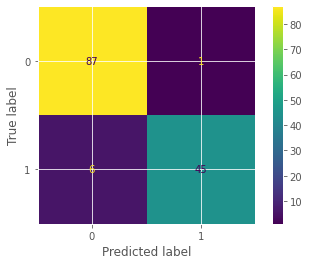

--------------------------------------
Model accuracy for test data  ('CART', 0.920863309352518)


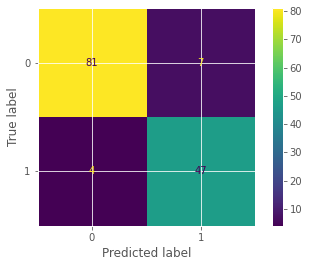

--------------------------------------
Model accuracy for test data  ('XGB', 0.9496402877697842)


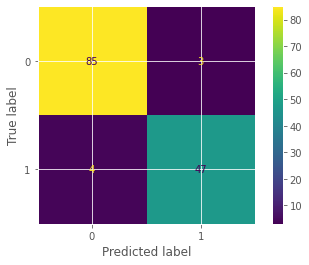

--------------------------------------
Model accuracy for test data  ('RF', 0.9496402877697842)


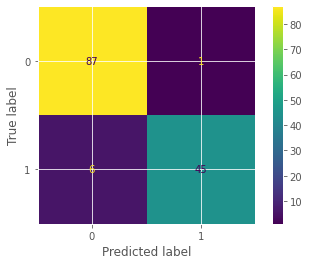

--------------------------------------


In [41]:
for name,model in models:
  model.fit(X_train, y_train) #train model
  y_pred=model.predict(X_test)
  print('Model accuracy for test data ',(name,metrics.accuracy_score(y_test, y_pred)))
  cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
  disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
  disp.plot()
  plt.show()
  print('--------------------------------------')
  

- Decision Tree and XGBoost model performance is better than the other two models in this given data set
